# Blind injection study 

In [99]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import corner

In [2]:
# read data
data = pd.read_csv("data.txt", sep = ",")
data.columns = data.columns.str.strip()

In [3]:
data.head()

,x,y1,y2,y3
0,-10.00000,-27.835948,-1.204022,32.752084
1,-9.97998,-29.139783,-2.574528,31.335606
2,-9.95996,-28.501142,-2.001794,31.858014
3,-9.93994,-27.178927,-0.744721,33.060393
4,-9.91992,-27.492202,-1.122373,32.623676


In [4]:
len(data['x'])

1000

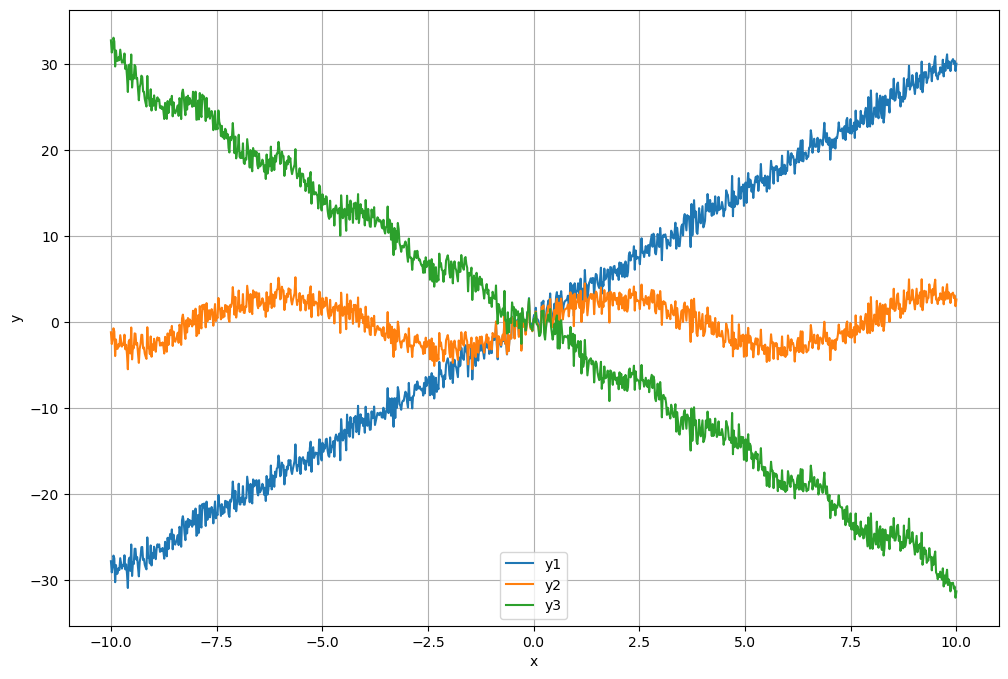

In [5]:
# plot data
plt.figure(figsize=(12, 8))
plt.plot(data['x'], data['y1'], label='y1')
plt.plot(data['x'], data['y2'], label='y2')
plt.plot(data['x'], data['y3'], label='y3')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

The statistical model is y ~ $N(f(x,\beta ),1)$ that each y is normally distributed with the mean of $f(x,\beta )$ and variance of 1. i.e., For i=,...,n,  $y_i  =f(x_i,\beta ) + e_i , e_i$ ~ N(0,1) 


## y1

$y_1 = \beta_0 + \beta_1*x + e$

$y_1 = \beta_0 + \beta_1*x + \beta_2 sin(\omega*x) +e$


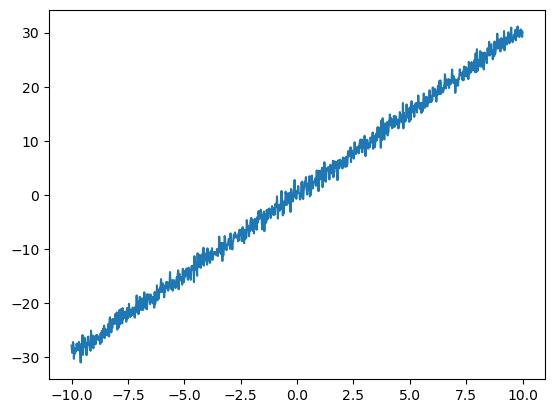

In [6]:
plt.plot(data['x'],data['y1'])

In [6]:
# Extracting y1 from the dataframe
x_data = data['x']
y1_data = data['y1']
# Defining the new model functions for y1
def y1_model_1(x, beta_0, beta_1):
    return beta_0 + beta_1 * x

def y1_model_2(x, beta_0, beta_1, beta_2, omega):
    return beta_0 + beta_1 * x + beta_2 * np.sin(omega * x)

def calculate_aic(n, ss_res, p):
    aic = n * np.log(ss_res / n) + 2 * p
    return aic

def calculate_bic(n, ss_res, p):
    bic = n * np.log(ss_res / n) + np.log(n) * p
    return bic

n = len(y1_data)
# Initial guesses for the parameters
initial_guesses_y1_model_1 = [1, 1]
initial_guesses_y1_model_2 = [1, 1, 1, 1]

# Fitting the models for y1
params_y1_model_1, cov_matrix_y1_model_1 = curve_fit(y1_model_1, x_data, y1_data, p0=initial_guesses_y1_model_1)
params_y1_model_2, cov_matrix_y1_model_2 = curve_fit(y1_model_2, x_data, y1_data, p0=initial_guesses_y1_model_2)

# Calculating the residuals and R-squared values for each model
residuals_y1_model_1 = y1_data - y1_model_1(x_data, *params_y1_model_1)
ss_res_y1_model_1 = np.sum(residuals_y1_model_1**2)
ss_tot_y1_model_1 = np.sum((y1_data - np.mean(y1_data))**2)
r_squared_y1_model_1 = 1 - (ss_res_y1_model_1 / ss_tot_y1_model_1)

residuals_y1_model_2 = y1_data - y1_model_2(x_data, *params_y1_model_2)
ss_res_y1_model_2 = np.sum(residuals_y1_model_2**2)
ss_tot_y1_model_2 = np.sum((y1_data - np.mean(y1_data))**2)
r_squared_y1_model_2 = 1 - (ss_res_y1_model_2 / ss_tot_y1_model_2)

# AIC and BIC for y1 Model 1
aic_y1_model_1 = calculate_aic(n, ss_res_y1_model_1, len(params_y1_model_1))
bic_y1_model_1 = calculate_bic(n, ss_res_y1_model_1, len(params_y1_model_1))

# AIC and BIC for y1 Model 2
aic_y1_model_2 = calculate_aic(n, ss_res_y1_model_2, len(params_y1_model_2))
bic_y1_model_2 = calculate_bic(n, ss_res_y1_model_2, len(params_y1_model_2))

results = {
    "r_squared_y1_model_1": r_squared_y1_model_1,
    "r_squared_y1_model_2": r_squared_y1_model_2,
    "aic_y1_model_1": aic_y1_model_1,
    "bic_y1_model_1": bic_y1_model_1,
    "aic_y1_model_2": aic_y1_model_2,
    "bic_y1_model_2": bic_y1_model_2,
}

results

{'r_squared_y1_model_1': 0.9967676061859799,
 'r_squared_y1_model_2': 0.9967765605709423,
 'aic_y1_model_1': -22.13301061387527,
 'bic_y1_model_1': -12.317500055910998,
 'aic_y1_model_2': -20.907057082374163,
 'bic_y1_model_2': -1.2760359664456153}

In [67]:
def model_y1(x, params):
    beta0, beta1 = params
    return beta0 + beta1 * x 


In [68]:
def log_likelihood_y1(y_obs, y_pred):
    log_l = np.sum(norm.logpdf(y_obs - y_pred, loc=0, scale=1))
    return log_l


In [69]:
def log_prior_y1(params):
    beta0, beta1 = params
    if -10 < beta0 < 10 and -10 < beta1 < 10:
        return 0
    else:
        return -np.inf


In [70]:
def metropolis_hastings_y1(y, x, n_iterations, initial_params_y1, step_sizes_y1):
    n_params = len(initial_params_y1)
    current_params = initial_params_y1
    current_log_prob = log_likelihood_y1(y, model_y1(x, current_params)) + log_prior_y1(current_params)
    

    chain = np.empty((n_iterations, n_params))
    chain[0] = current_params  # set initial params
    n_accepted = 0
    
    for i in range(1, n_iterations):  
        # generate proposed params
        proposed_params = current_params + np.random.normal(0, step_sizes_y1, n_params)
        proposed_log_prob = log_likelihood_y1(y, model_y1(x, proposed_params)) + log_prior_y1(proposed_params)
        

        if proposed_log_prob - current_log_prob > np.log(np.random.rand()):
            current_params = proposed_params
            current_log_prob = proposed_log_prob
            n_accepted += 1
        # Adds the current parameter set to the chain, regardless of whether the proposal is accepted
        chain[i] = current_params
    
    acceptance_rate = n_accepted / (n_iterations - 1)  
    return chain, acceptance_rate

In [79]:

initial_params_y1 = [0, 3]  
iterations = 10000  #
step_size_y1 = [0.01,0.01]  

chain, acceptance_rate = metropolis_hastings_y1(data['y1'], data['x'], iterations, initial_params_y1, step_size_y1)




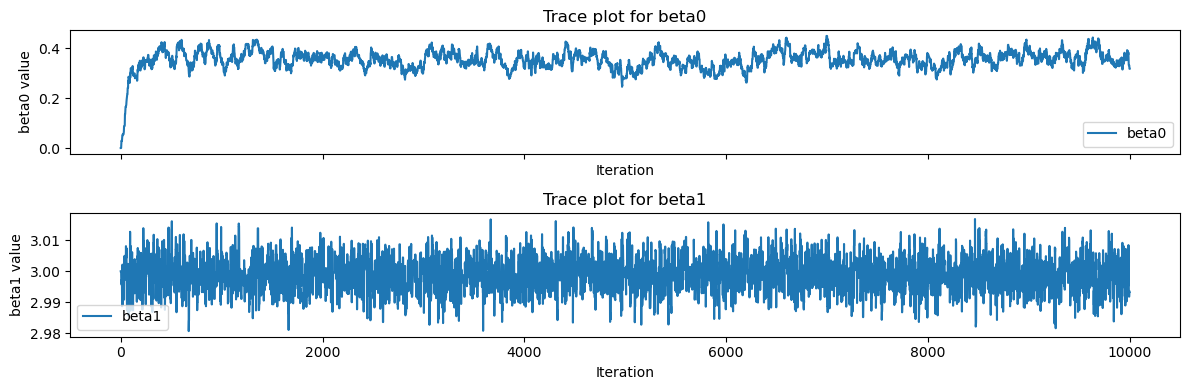

In [80]:
def plot_trace(chain, param_names):
    n_iterations, n_params = chain.shape
    
    fig, axes = plt.subplots(n_params, figsize=(12, 2 * n_params), sharex=True)
    
    for i in range(n_params):
        ax = axes[i]
        ax.plot(chain[:, i], label=f'{param_names[i]}')
        ax.set_title(f'Trace plot for {param_names[i]}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel(f'{param_names[i]} value')
        ax.legend()
    
    fig.tight_layout()
    plt.show()
    
param_names_y1 = ['beta0','beta1']
plot_trace(chain, param_names_y1)

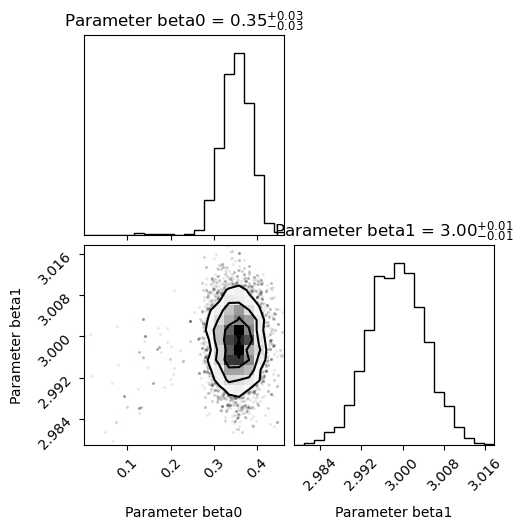

In [11]:

fig = corner.corner(chain, labels=[f'Parameter {param_names_y1[i]}' for i in range(chain.shape[1])], 
                    show_titles=True, title_kwargs={"fontsize": 12})

plt.show()


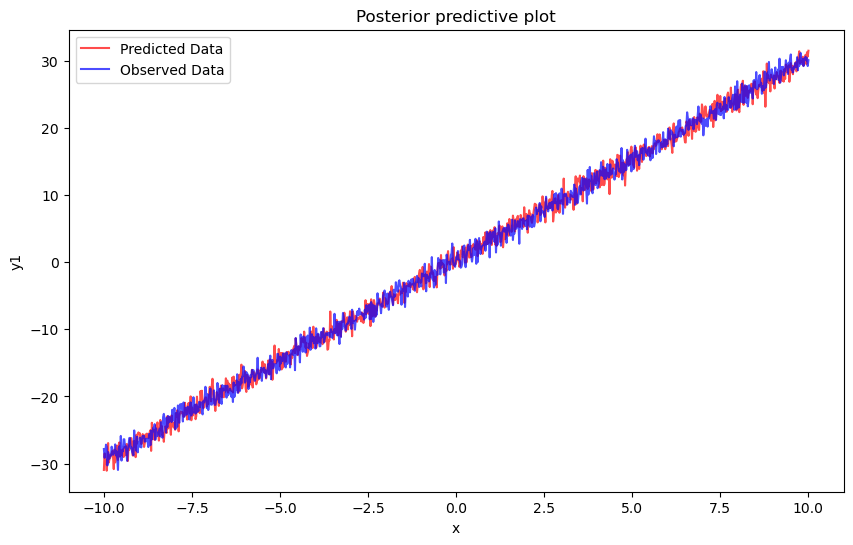

In [88]:
def posterior_predictive_y1(chain, x, n_samples=100):
    plt.figure(figsize=(10, 6))
    
    mean_beta0, mean_beta1 = np.mean(chain[-100:, :2], axis=0)
    
    y_pred = model_y1(x, [mean_beta0, mean_beta1]) + np.random.normal(loc=0, scale=1, size=len(x))
    
    plt.plot(x,y_pred, color='red', alpha=0.7,label='Predicted Data')
    plt.plot(x, data['y1'], color='blue', alpha=0.7, label='Observed Data')
    plt.title('Posterior predictive plot')
    plt.xlabel('x')
    plt.ylabel('y1')
    plt.legend()
    plt.show()
    
posterior_predictive_y1(chain, data['x'])


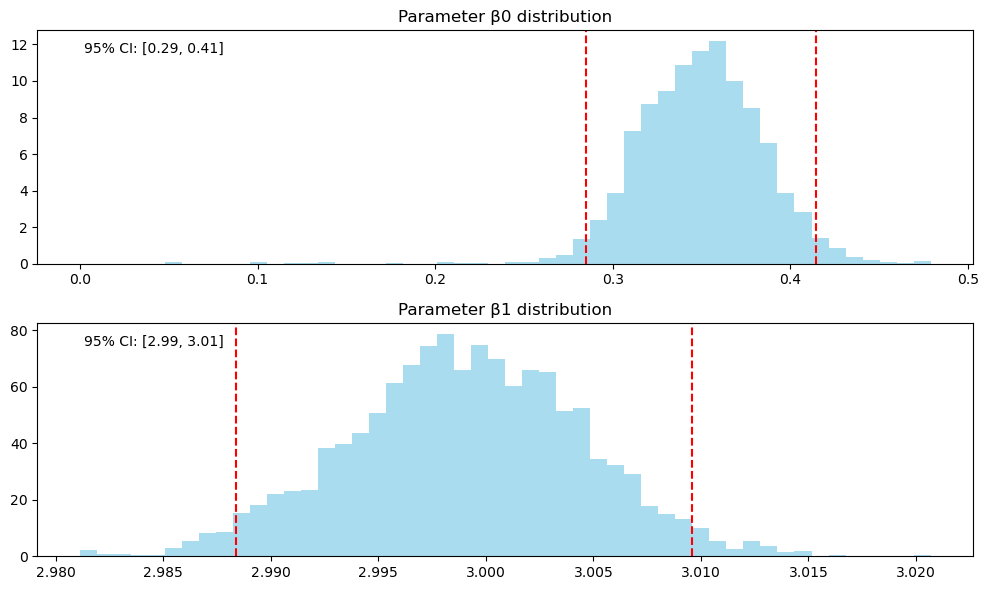

array([2.98837982, 3.00958953])

In [76]:
def confidence_intervals(chain):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    beta0_chain, beta1_chain = chain[:,0], chain[:,1]
    
    for i, beta_chain in enumerate([beta0_chain, beta1_chain]):
        ax = axes[i]
        ax.hist(beta_chain, bins=50, density=True, alpha=0.7, color='skyblue')
        ax.set_title(f"Parameter β{i} distribution")
        confidence_interval = np.percentile(beta_chain, [2.5, 97.5])
        for ci in confidence_interval:
            ax.axvline(ci, color='red', linestyle='--')
        ax.text(0.05, 0.95, f"95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]",
                transform=ax.transAxes, verticalalignment='top')
        
    plt.tight_layout()
    plt.show()

    return confidence_interval

confidence_intervals(chain)

In [62]:
def run_mcmc(y, x, n_iterations, n_walkers, step_size_y1, initial_params_range_y1):
    # store all chains of walkers
    chains = np.empty((n_walkers, n_iterations, len(initial_params_range_y1)))
    
    
    for w in range(n_walkers):
        # set initial params from the range
        initial_params = [np.random.uniform(low, high) for low, high in initial_params_range_y1]
        
        # do Metropolis-Hastings
        chain,acce = metropolis_hastings_y1(y, x, n_iterations, initial_params, step_size_y1)
        
        
        chains[w, :, :] = chain
    
    return chains

n_walkers = 10
initial_params_range_y1 = [(0, 1), (2,5)]  


chains = run_mcmc(data['y1'], data['x'], 10000, n_walkers, step_size_y1, initial_params_range_y1)

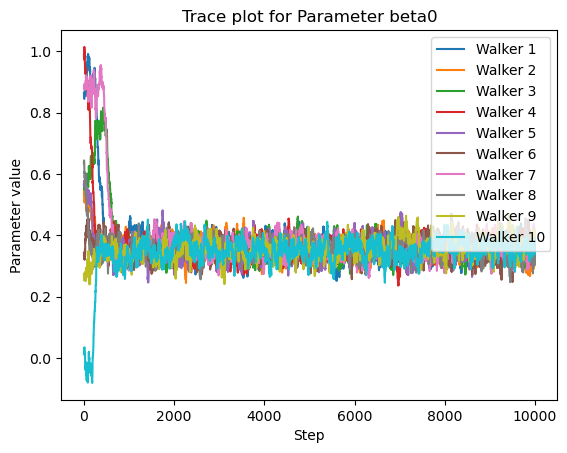

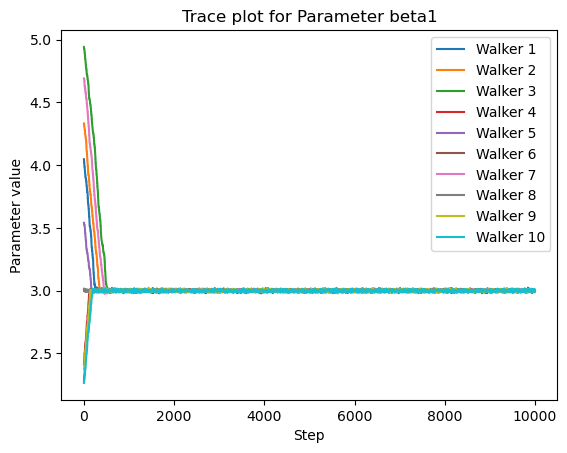

In [69]:

for id in range(2):
    param_id = id  
    for i in range(n_walkers):
        plt.plot(chains[i, :, param_id], label=f'Walker {i+1}')
    plt.title(f'Trace plot for Parameter {param_names_y1[param_id]}')
    plt.xlabel('Step')
    plt.ylabel('Parameter value')
    plt.legend()
    plt.show()


## y2

According to the observation, y2 has a large periodic oscillation mode and a small oscillation mode. So there are 2 possible candidate models:
1. $y_2 = \beta_0 + \beta_1 sin(\omega x) + e$
2. $y_2 = \beta_0 + \beta_1 sin(\omega_1 x) + \beta_2 sin(\omega_2 x) + e$

In [7]:
from scipy.optimize import curve_fit
import numpy as np

x_data = data['x']
y2_data = data['y2']
# Defining the model functions
def y2_model_1(x, beta_0, beta_1, omega):
    return beta_0 + beta_1 * np.sin(omega * x)

def y2_model_2(x, beta_0, beta_1, omega_1, beta_2, omega_2):
    return beta_0 + beta_1 * np.sin(omega_1 * x) + beta_2 * np.sin(omega_2 * x)

def calculate_aic(n, ss_res, p):
    aic = n * np.log(ss_res / n) + 2 * p
    return aic

def calculate_bic(n, ss_res, p):
    bic = n * np.log(ss_res / n) + np.log(n) * p
    return bic

initial_guesses_y2_model_1 = [1, 1, 1]
initial_guesses_y2_model_2 = [1, 1, 1, 1, 1]

n = len(y2_data)
# Fitting the models for y1
params_y2_model_1, cov_matrix_y2_model_1 = curve_fit(y2_model_1, x_data, y2_data, p0=initial_guesses_y2_model_1)
params_y2_model_2, cov_matrix_y2_model_2 = curve_fit(y2_model_2, x_data, y2_data, p0=initial_guesses_y2_model_2)

# Calculating the residuals and R-squared values for each model
residuals_y2_model_1 = y2_data - y2_model_1(x_data, *params_y2_model_1)
ss_res_y2_model_1 = np.sum(residuals_y2_model_1**2)
ss_tot_y2_model_1 = np.sum((y2_data - np.mean(y2_data))**2)
r_squared_y2_model_1 = 1 - (ss_res_y2_model_1 / ss_tot_y2_model_1)

residuals_y2_model_2 = y2_data - y2_model_2(x_data, *params_y2_model_2)
ss_res_y2_model_2 = np.sum(residuals_y2_model_2**2)
ss_tot_y2_model_2 = np.sum((y2_data - np.mean(y2_data))**2)
r_squared_y2_model_2 = 1 - (ss_res_y2_model_2 / ss_tot_y2_model_2)

# AIC and BIC for y1 Model 1
aic_y2_model_1 = calculate_aic(n, ss_res_y2_model_1, len(params_y2_model_1))
bic_y2_model_1 = calculate_bic(n, ss_res_y2_model_1, len(params_y2_model_1))

# AIC and BIC for y1 Model 2
aic_y2_model_2 = calculate_aic(n, ss_res_y2_model_2, len(params_y2_model_2))
bic_y2_model_2 = calculate_bic(n, ss_res_y2_model_2, len(params_y2_model_2))

results = {
    "r_squared_y2_model_1": r_squared_y2_model_1,
    "r_squared_y2_model_2": r_squared_y2_model_2,
    "aic_y2_model_1": aic_y2_model_1,
    "bic_y2_model_1": bic_y2_model_1,
    "aic_y2_model_2": aic_y2_model_2,
    "bic_y2_model_2": bic_y2_model_2,
}

results


{'r_squared_y2_model_1': 0.8242801364110632,
 'r_squared_y2_model_2': 0.8242801364109251,
 'aic_y2_model_1': -20.29907004636037,
 'bic_y2_model_1': -5.57580420941396,
 'aic_y2_model_2': -16.2990700455747,
 'bic_y2_model_2': 8.239706349335982}

In [24]:
params_y2_model_1

array([-0.0452567 ,  2.99667751,  0.79887534])

In [89]:
def model_y2(x,params):
    beta0, beta1, omega = params
    return beta0 + beta1 * np.sin(omega * x)

In [90]:
def log_likelihood_y2(y_obs, y_pred):
    log_l = np.sum(norm.logpdf(y_obs - y_pred, loc=0, scale=1))
    return log_l

In [91]:
def log_prior_y2(params):
    beta0, beta1, omega = params
    if -10 < beta0 < 10 and -10 < beta1 < 10 and 0 < omega < 10:
        return 0
    else:
        return -np.inf

In [92]:
def metropolis_hastings_y2(y, x, n_iterations, initial_params, step_sizes):
    n_params = len(initial_params)
    current_params = initial_params
    current_log_prob = log_likelihood_y2(y, model_y2(x, current_params)) + log_prior_y2(current_params)
    
    
    chain = np.empty((n_iterations, n_params))
    chain[0] = current_params  # 设置初始参数
    n_accepted = 0
    
    for i in range(1, n_iterations):  
        # 生成提议参数，这里直接用数组广播而非列表推导式
        proposed_params = current_params + np.random.normal(0, step_sizes, n_params)
        proposed_log_prob = log_likelihood_y2(y, model_y2(x, proposed_params)) + log_prior_y2(proposed_params)
        
        # 接受或拒绝提议，这里使用与mh1相同的逻辑
        if proposed_log_prob - current_log_prob > np.log(np.random.rand()):
            current_params = proposed_params
            current_log_prob = proposed_log_prob
            n_accepted += 1
        # 将当前参数集添加到链中，无论提议是否被接受
        chain[i] = current_params
    
    acceptance_rate = n_accepted / (n_iterations - 1)  # 减1因为初始参数不计入接受率
    return chain, acceptance_rate


In [148]:
n_iterations = 20000
initial_params_y2 = [0, 1, 1]  # 适当的初始参数
step_sizes_y2 = [0.02, 0.1, 0.03]  # 每个参数的步长



In [ ]:
chain_y2, acceptance_rate= metropolis_hastings_y2(data['y2'], data['x'], n_iterations, initial_params_y2, step_sizes_y2)

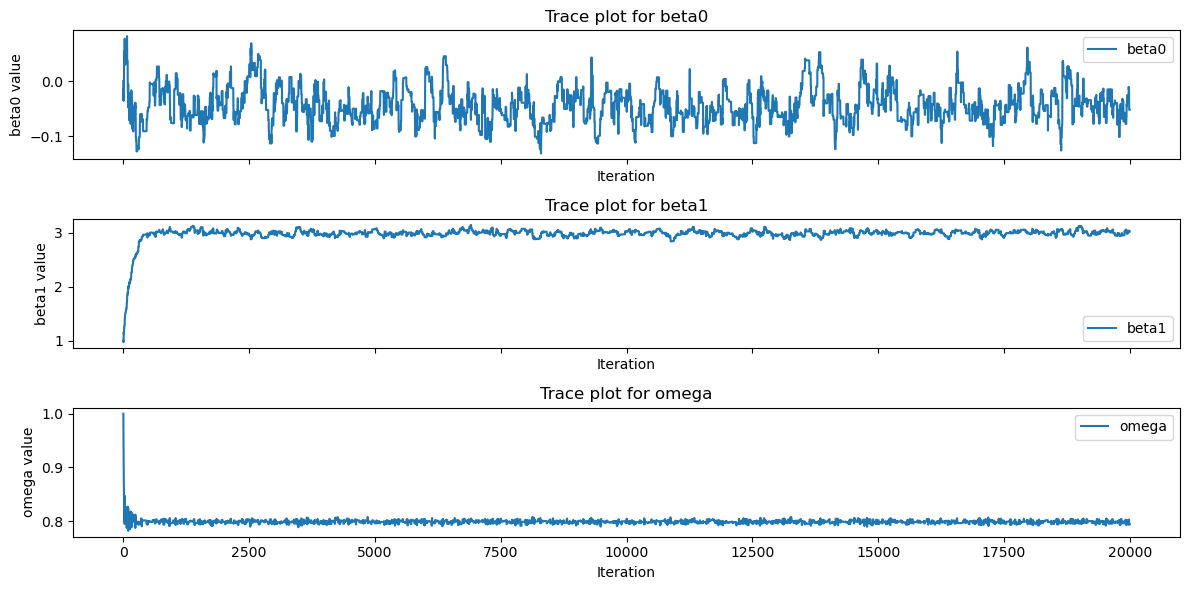

In [145]:

# Define your parameter names based on your model
param_names_y2 = ['beta0', 'beta1', 'omega']

# Call the function with the chain from your MCMC algorithm
plot_trace(chain_y2, param_names_y2)

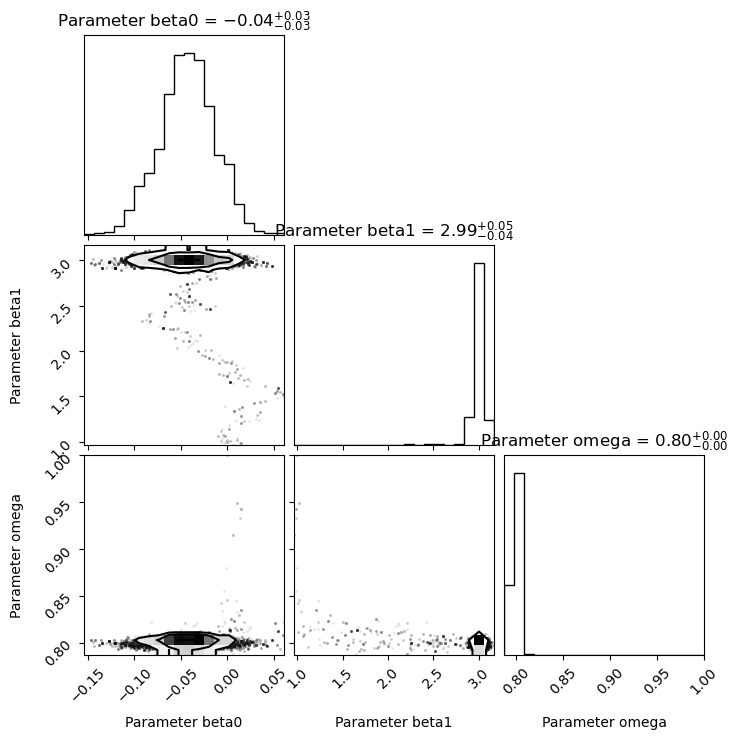

In [103]:
fig_y2 = corner.corner(chain, labels=[f'Parameter {param_names_y2[i]}' for i in range(chain.shape[1])], 
                    show_titles=True, title_kwargs={"fontsize": 12})

plt.show()

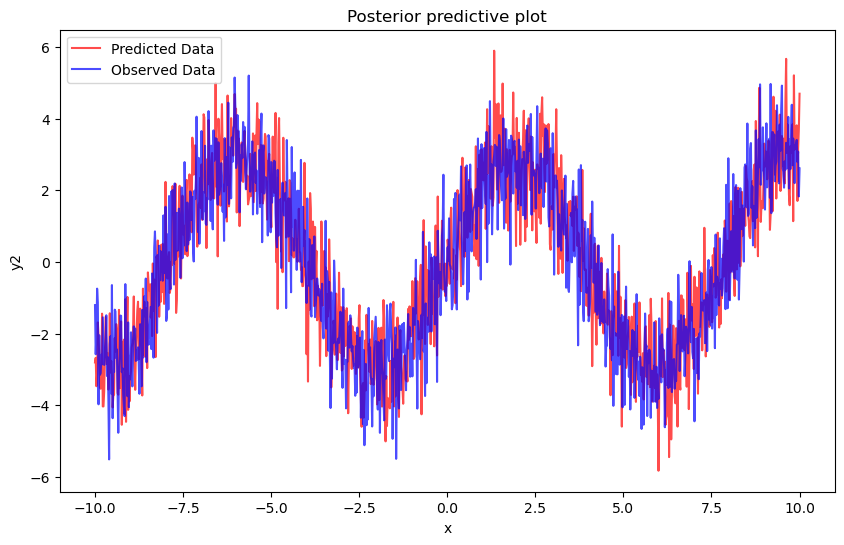

In [104]:
def posterior_predictive_y2(chain, x, n_samples=100):
    plt.figure(figsize=(10, 6))
    
    mean_beta0, mean_beta1, mean_omega = np.mean(chain[-100:, :3], axis=0)
    
    y_pred = model_y2(x, [mean_beta0, mean_beta1,mean_omega]) + np.random.normal(loc=0, scale=1, size=len(x))
    
    plt.plot(x,y_pred, color='red', alpha=0.7,label='Predicted Data')
    plt.plot(x, data['y2'], color='blue', alpha=0.7, label='Observed Data')
    plt.title('Posterior predictive plot')
    plt.xlabel('x')
    plt.ylabel('y2')
    plt.legend()
    plt.show()
    
posterior_predictive_y2(chain, data['x'])

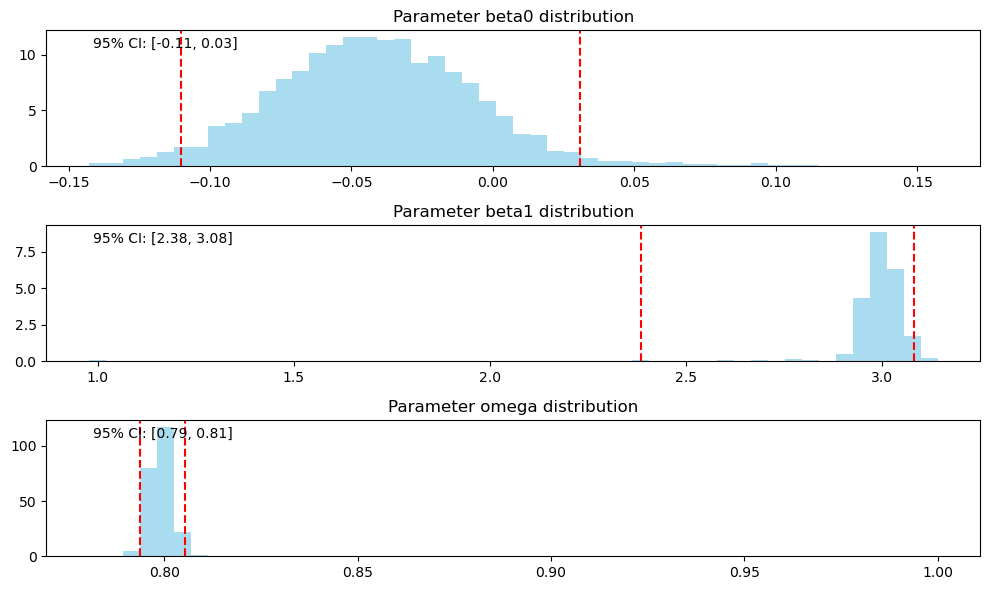

array([0.79368935, 0.80524832])

In [97]:
def confidence_intervals_y2(chain):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6))
    beta0_chain, beta1_chain, omega = chain[:,0], chain[:,1], chain[:,2]
    
    for i, chain in enumerate([beta0_chain, beta1_chain, omega]):
        ax = axes[i]
        ax.hist(chain, bins=50, density=True, alpha=0.7, color='skyblue')
        ax.set_title(f"Parameter {param_names_y2[i]} distribution")
        confidence_interval = np.percentile(chain, [2.5, 97.5])
        for ci in confidence_interval:
            ax.axvline(ci, color='red', linestyle='--')
        ax.text(0.05, 0.95, f"95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]",
                transform=ax.transAxes, verticalalignment='top')
        
    plt.tight_layout()
    plt.show()

    return confidence_interval

confidence_intervals_y2(chain)

In [149]:
def run_mcmc_y2(y,x , n_iterations, n_walkers, step_size_y2, initial_params_y2):
    chains = np.empty((n_walkers, n_iterations, len(initial_params_y2)))
    
    for w in range(n_walkers):
        init_params = np.random.normal(initial_params_y2, step_sizes_y2)
        
        chain, accept= metropolis_hastings_y2(y, x, n_iterations, init_params, step_sizes_y2)
        
        chains[w, :, :] = chain
        
    return chains

n_walkers = 10


chains_y2 = run_mcmc_y2(data['y2'], data['x'], 10000, n_walkers, step_sizes_y2, initial_params_y2)

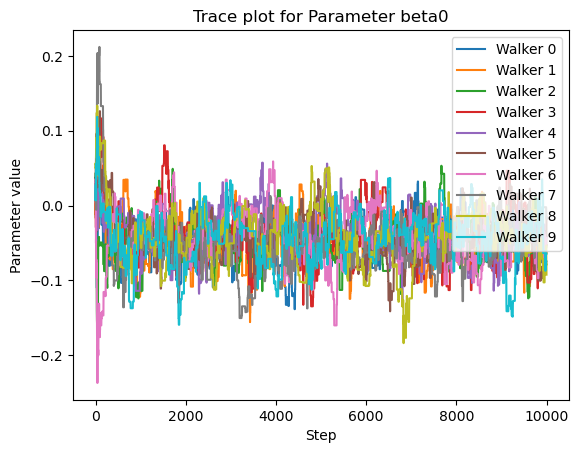

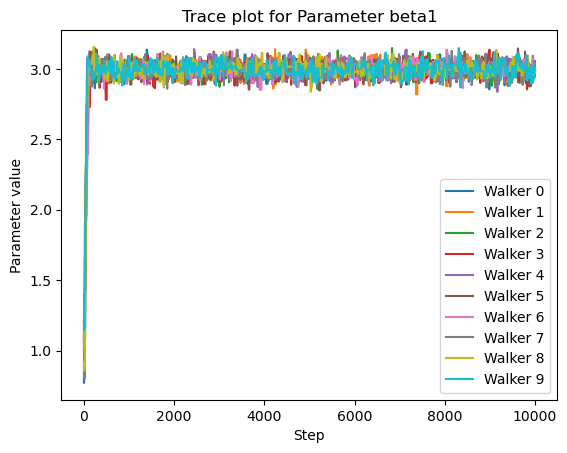

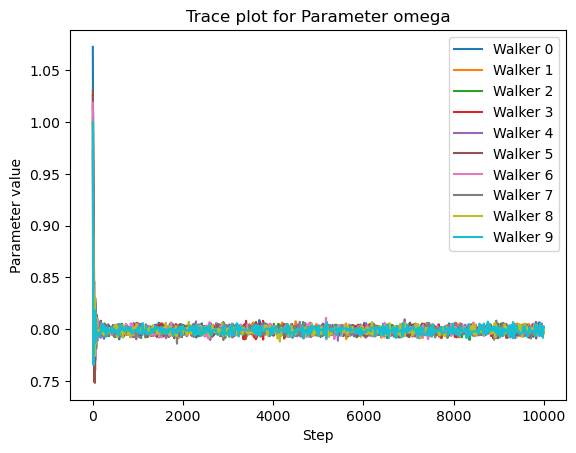

In [150]:
param_names = ['beta0', 'beta1', 'omega']
for id in range(3):
    param_id = id  
    for i in range(n_walkers):
        plt.plot(chains_y2[i, :, param_id], label=f'Walker {i}')
    plt.title(f'Trace plot for Parameter {param_names[param_id]}')
    plt.xlabel('Step')
    plt.ylabel('Parameter value')
    plt.legend()
    plt.show()

In [167]:
np.random.normal(initial_params_y2, step_sizes_y2)

array([-0.03726083,  1.07834324,  0.98604391])

In [28]:
acceptance_rate

0.19560978048902444

100%|███████████████████████████████████████| 5000/5000 [01:16<00:00, 65.63it/s]


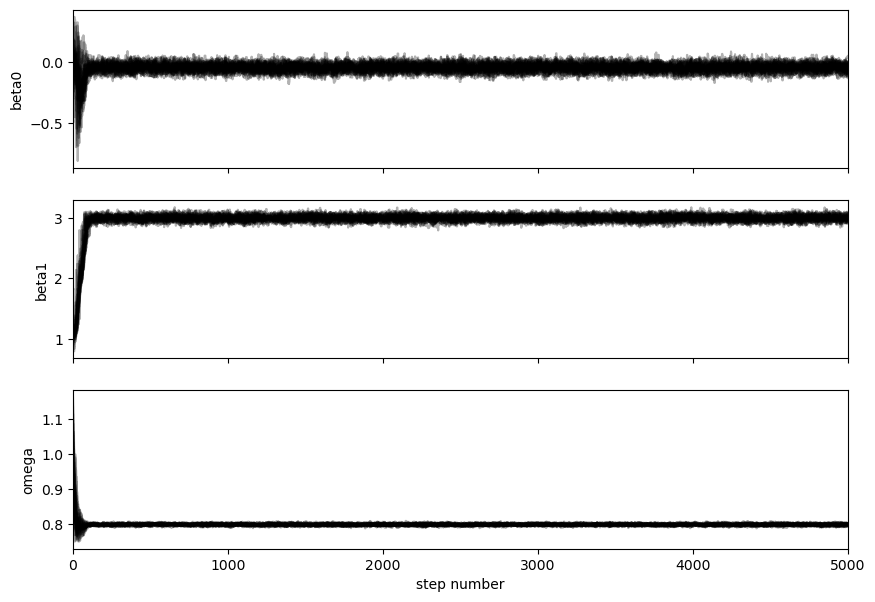

In [31]:
import emcee


def log_likelihood_y2(params, x, y):
    beta0, beta1, omega = params
    model = beta0 + beta1 * np.sin(omega * x) 
    log_l = np.sum(norm.logpdf(y - model, loc=0, scale=1))
    return log_l

# 对数先验函数
def log_prior(params):
    beta0, beta1, omega = params
    if -10 < beta0 < 10 and -10 < beta1 < 10 and -10 < omega < 10:
        return 0.0
    return -np.inf

# 总的对数后验概率函数
def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_y2(params, x, y)

# emcee的参数设置
nwalkers = 32
ndim = 3
pos = [np.array([0, 1, 1]) + 0.1 * np.random.randn(ndim) for i in range(nwalkers)]

# 设置sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data['x'], data['y2']))

# 执行MCMC采样，这里做一个较小的迭代次数示例
sampler.run_mcmc(pos, 5000, progress=True)

# 绘制迹线图
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["beta0", "beta1", "omega"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("step number")
plt.show()


## y3

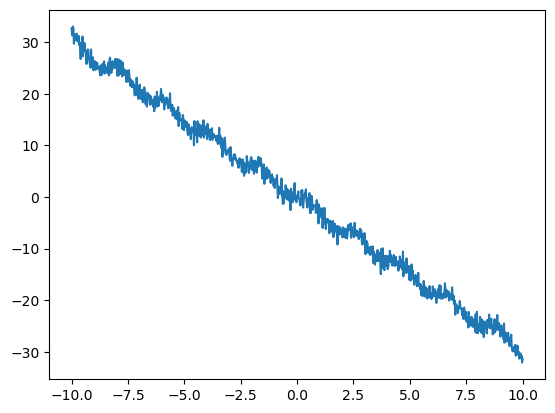

In [68]:
plt.plot(data['x'], data['y3'], label='y3')

$y_3 = \beta_0 + \beta_1 x + \beta_2 sin(\omega x) + e$

$y_3 = \beta_0 + \beta_1 x + \beta_2 sin(\omega_1 x) + \beta_3 sin(\omega_2 x) + e$

In [55]:
x_data = data['x']
y3_data = data['y3']
# Defining the model functions
def y3_model_1(x, beta_0, beta_1, beta_2, omega):
    return beta_0 + beta_1 * x + beta_2 * np.sin(omega * x)

def y3_model_2(x, beta_0, beta_1, beta_2, omega_1, beta_3, omega_2):
    return beta_0 + beta_1 * x + beta_2 * np.sin(omega_1 * x) + beta_3 * np.sin(omega_2 * x)

def calculate_aic(n, ss_res, p):
    aic = n * np.log(ss_res / n) + 2 * p
    return aic

def calculate_bic(n, ss_res, p):
    bic = n * np.log(ss_res / n) + np.log(n) * p
    return bic

initial_guesses_y3_model_1 = [1, 1, 1, 1]
initial_guesses_y3_model_2 = [1, 1, 1, 1, 1, 1]

n = len(y3_data)
# Fitting the models for y1
params_y3_model_1, cov_matrix_y3_model_1 = curve_fit(y3_model_1, x_data, y3_data, p0=initial_guesses_y3_model_1)
params_y3_model_2, cov_matrix_y3_model_2 = curve_fit(y3_model_2, x_data, y3_data, p0=initial_guesses_y3_model_2)

# Calculating the residuals and R-squared values for each model
residuals_y3_model_1 = y3_data - y3_model_1(x_data, *params_y3_model_1)
ss_res_y3_model_1 = np.sum(residuals_y3_model_1**2)
ss_tot_y3_model_1 = np.sum((y3_data - np.mean(y3_data))**2)
r_squared_y3_model_1 = 1 - (ss_res_y3_model_1 / ss_tot_y3_model_1)

residuals_y3_model_2 = y3_data - y3_model_2(x_data, *params_y3_model_2)
ss_res_y3_model_2 = np.sum(residuals_y3_model_2**2)
ss_tot_y3_model_2 = np.sum((y3_data - np.mean(y3_data))**2)
r_squared_y3_model_2 = 1 - (ss_res_y3_model_2 / ss_tot_y3_model_2)

# AIC and BIC for y1 Model 1
aic_y3_model_1 = calculate_aic(n, ss_res_y3_model_1, len(params_y3_model_1))
bic_y3_model_1 = calculate_bic(n, ss_res_y3_model_1, len(params_y3_model_1))

# AIC and BIC for y1 Model 2
aic_y3_model_2 = calculate_aic(n, ss_res_y3_model_2, len(params_y3_model_2))
bic_y3_model_2 = calculate_bic(n, ss_res_y3_model_2, len(params_y3_model_2))

results = {
    "r_squared_y3_model_1": r_squared_y3_model_1,
    "r_squared_y3_model_2": r_squared_y3_model_2,
    "aic_y3_model_1": aic_y3_model_1,
    "bic_y3_model_1": bic_y3_model_1,
    "aic_y3_model_2": aic_y3_model_2,
    "bic_y3_model_2": bic_y3_model_2,
}

results

{'r_squared_y3_model_1': 0.9946783923727517,
 'r_squared_y3_model_2': 0.9946814850480286,
 'aic_y3_model_1': 485.21451666432984,
 'bic_y3_model_1': 504.8455377802584,
 'aic_y3_model_2': 488.6331934059,
 'bic_y3_model_2': 518.0797250797928}

In [56]:
params_y3_model_1

array([-0.04525668, -3.00543746, -0.09707904,  1.23677418])

In [105]:
def model_y3(x, params):
    beta0, beta1, beta2, omega = params
    return beta0 + beta1 * x + beta2 * np.sin(omega * x) 

In [106]:
def log_likelihood_y3(y_obs, y_pred):
    log_l = np.sum(norm.logpdf(y_obs - y_pred, loc=0, scale=1))
    return log_l

In [107]:
def log_prior_y3(params):
    beta0, beta1, beta2, omega = params
    if -10 < beta0 < 10 and -10 < beta1 < 10 and -10 < beta2 < 10 and-10 < omega < 10 :
        return 0
    else:
        return -np.inf

In [108]:
def metropolis_hastings_y3(y, x, n_iterations, initial_params_y3, step_sizes_y3):
    n_params = len(initial_params_y3)
    current_params = initial_params_y3
    current_log_prob = log_likelihood_y3(y, model_y3(x, current_params)) + log_prior_y3(current_params)
    

    chain = np.empty((n_iterations, n_params))
    chain[0] = current_params  # 设置初始参数
    n_accepted = 0
    
    for i in range(1, n_iterations):  
        # 生成提议参数，这里直接用数组广播而非列表推导式
        proposed_params = current_params + np.random.normal(0, step_sizes_y3, n_params)
        proposed_log_prob = log_likelihood_y3(y, model_y3(x, proposed_params)) + log_prior_y3(proposed_params)
        
        # 接受或拒绝提议，这里使用与mh1相同的逻辑
        if proposed_log_prob - current_log_prob > np.log(np.random.rand()):
            current_params = proposed_params
            current_log_prob = proposed_log_prob
            n_accepted += 1
        # 将当前参数集添加到链中，无论提议是否被接受
        chain[i] = current_params
    
    acceptance_rate = n_accepted / (n_iterations - 1)  # 减1因为初始参数不计入接受率
    return chain, acceptance_rate

In [130]:
n_iterations = 20000
initial_params_y3 = [1, -3, 2, 3]  
step_sizes_y3 = [0.01, 0.01, 0.03, 0.03]  

chain_y3, acceptance_rate= metropolis_hastings_y3(data['y3'], data['x'], n_iterations, initial_params_y3, step_sizes_y3)

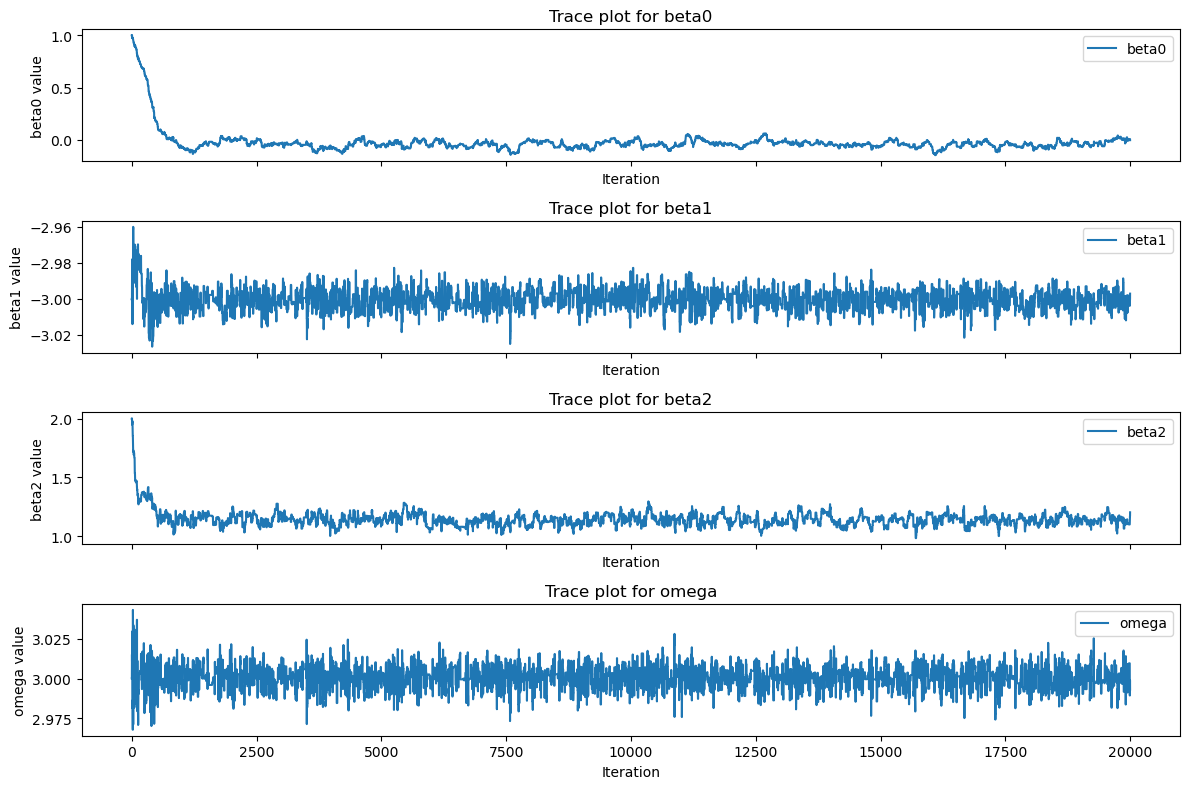

In [131]:
# Define your parameter names based on your model
param_names_y3 = ['beta0', 'beta1', 'beta2', 'omega']

# Call the function with the chain from your MCMC algorithm
plot_trace(chain, param_names_y3)

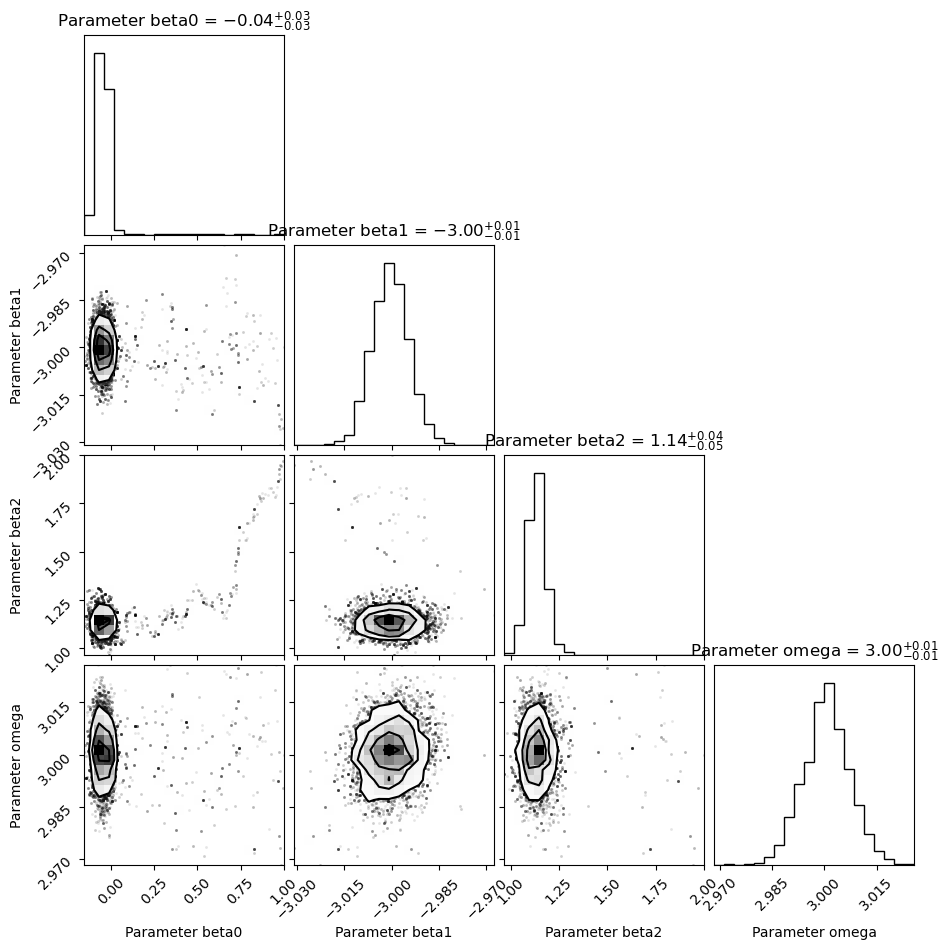

In [132]:
fig_y3= corner.corner(chain_y3, labels=[f'Parameter {param_names_y3[i]}' for i in range(chain.shape[1])], 
                    show_titles=True, title_kwargs={"fontsize": 12})

plt.show()

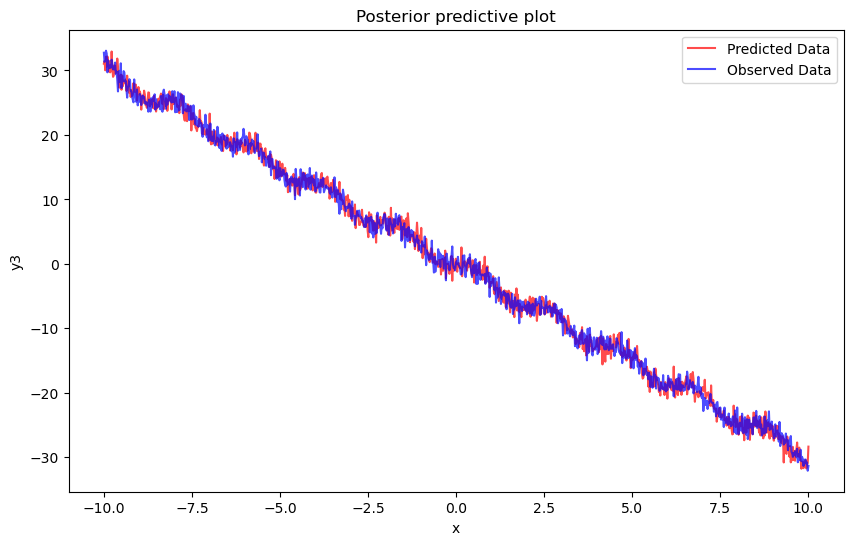

In [133]:
def posterior_predictive_y3(chain, x):
    plt.figure(figsize=(10, 6))
    
    mean_beta0, mean_beta1,mean_beta2 ,mean_omega = np.mean(chain[-100:, :4], axis=0)
    
    y_pred = model_y3(x, [mean_beta0, mean_beta1,mean_beta2, mean_omega]) + np.random.normal(loc=0, scale=1, size=len(x))
    
    plt.plot(x,y_pred, color='red', alpha=0.7,label='Predicted Data')
    plt.plot(x, data['y3'], color='blue', alpha=0.7, label='Observed Data')
    plt.title('Posterior predictive plot')
    plt.xlabel('x')
    plt.ylabel('y3')
    plt.legend()
    plt.show()
    
posterior_predictive_y3(chain_y3, data['x'])

In [139]:
def run_mcmc_y3(y,x , n_iterations, n_walkers, step_size_y3, initial_params_y3):
    chains = np.empty((n_walkers, n_iterations, len(initial_params_range_y3)))
    
    for w in range(n_walkers):
        init_params = np.random.normal(initial_params_y3, step_sizes_y3)
        
        chain, accept= metropolis_hastings_y3(y, x, n_iterations, init_params, step_sizes_y3)
        
        chains[w, :, :] = chain
        
    return chains

n_walkers = 10
# initial_params_range_y3 = [(-1, 1), (-4,0), (1,2),(2,4)]

chains_y3 = run_mcmc_y3(data['y3'], data['x'], 10000, n_walkers, step_sizes_y3, initial_params_y3)


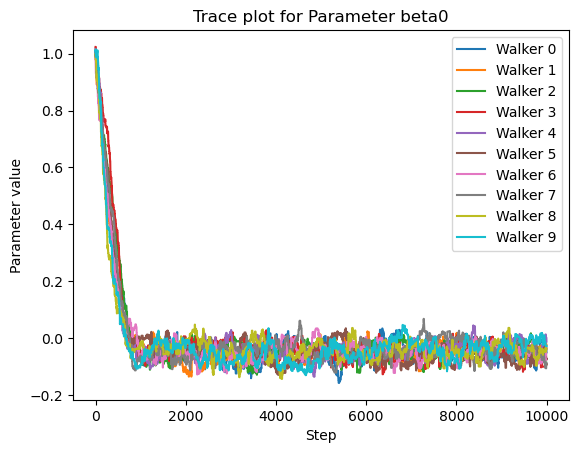

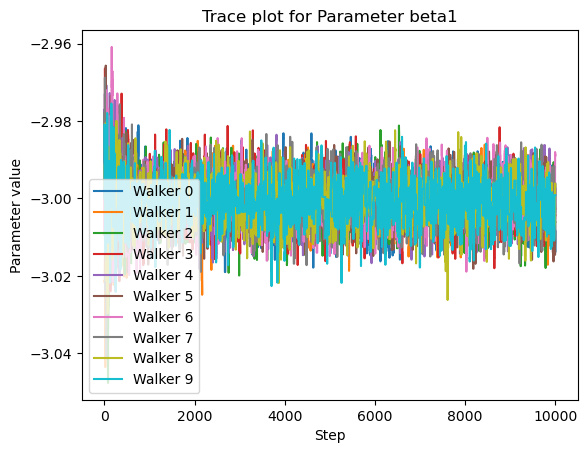

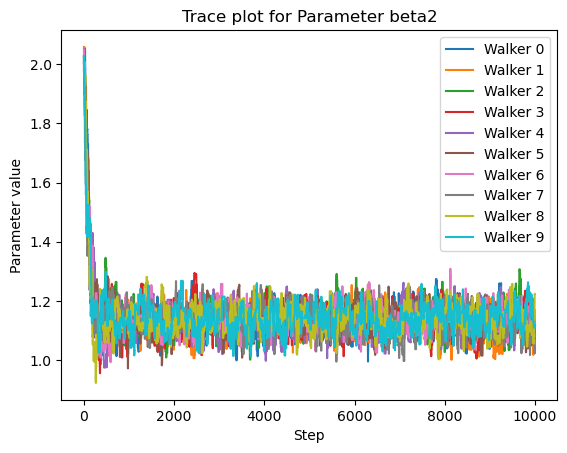

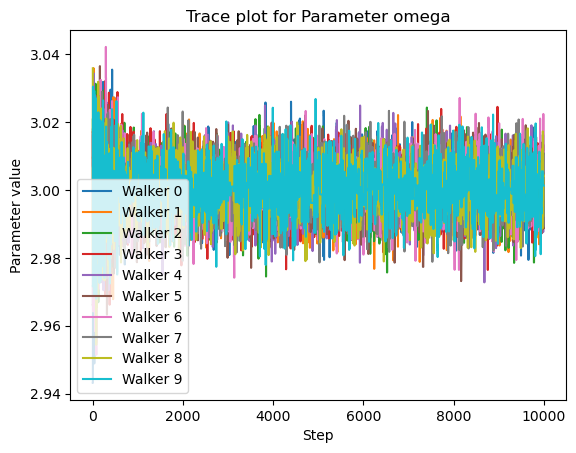

In [140]:

for id in range(4):
    param_id = id  
    for i in range(n_walkers):
        plt.plot(chains_y3[i, :, param_id], label=f'Walker {i}')
    plt.title(f'Trace plot for Parameter {param_names_y3[param_id]}')
    plt.xlabel('Step')
    plt.ylabel('Parameter value')
    plt.legend()
    plt.show()

100%|█████████████████████████████████████| 10000/10000 [03:10<00:00, 52.56it/s]


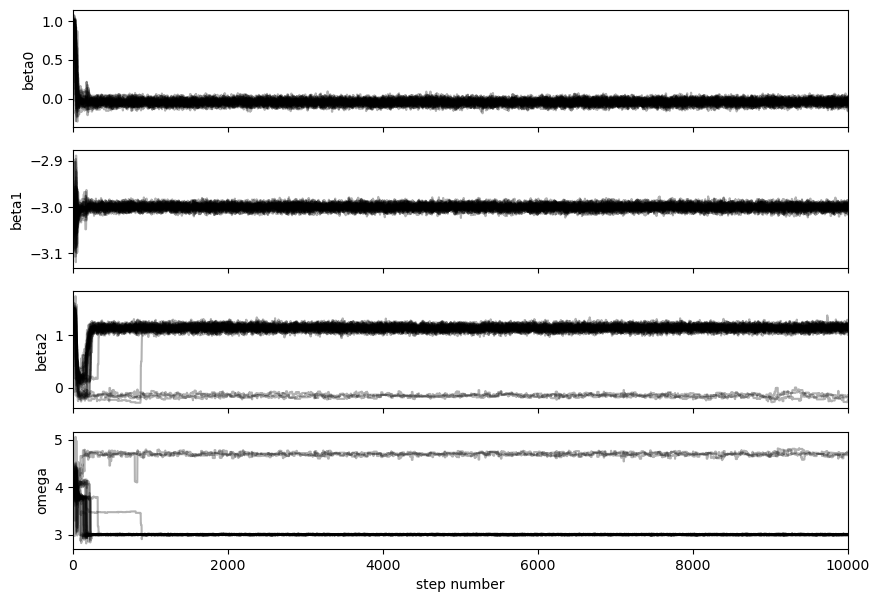

In [65]:


def log_probability_y3(params, x, y):
    lp = log_prior_y3(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_y3(y, model_y3(x, params))

# emcee的参数设置
nwalkers = 32
ndim = 4
pos = [np.array([1, -3, 1.5, 4]) + 0.01 * np.random.randn(ndim) for i in range(nwalkers)]

# 设置sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_y3, args=(data['x'], data['y3']))


sampler.run_mcmc(pos, 10000, progress=True)

# 绘制迹线图
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_names_y3[i])
axes[-1].set_xlabel("step number")
plt.show()